In [1]:
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=50)

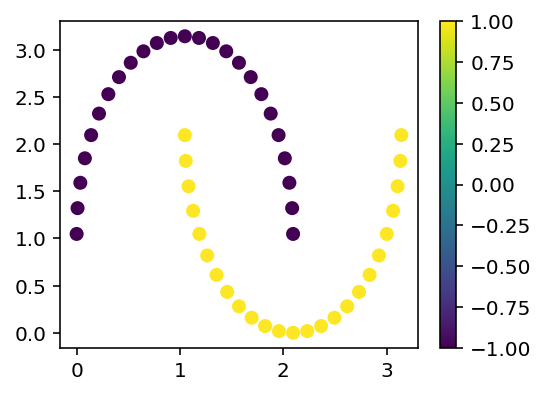

In [2]:
def normalize(x):
    """
    Переводит значения в интервал от 0 до pi
    """
    min_ = x.min()
    max_ = x.max()
    return np.pi * (x - min_) / (max_ - min_)

x[:, 0] = normalize(x[:, 0])
x[:, 1] = normalize(x[:, 1])
y = y * 2 - 1

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar(cb)
plt.show()

In [3]:
dev = qml.device("default.qubit", 2)

def encoding(x1, x2):
    qml.RY(x1, wires=0)
    qml.RY(x2, wires=1)
    qml.RZ(x1, wires=0)
    qml.RZ(x2, wires=1)
    qml.CZ(wires=[0, 1])

In [4]:
def layer(theta):
    qml.Rot(theta[0, 0], theta[0, 1], theta[0, 2], wires=0)
    qml.Rot(theta[1, 0], theta[1, 1], theta[1, 2], wires=1)
    qml.CZ(wires=[0, 1])

In [5]:
@qml.qnode(dev)
def node(x1, x2, q):
    encoding(x1, x2)
    for q_ in q:
        layer(q_)

    return qml.expval(qml.PauliZ(0) @ qml.PauliY(1))

In [6]:
def apply_node(x, q):
    res = []

    for x_ in x:
        vqc_output = node(x_[0], x_[1], q[0])
        res.append(vqc_output + q[1])

    return res

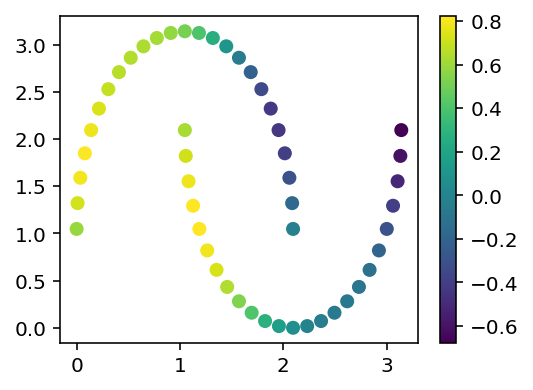

In [7]:
np.random.seed(42)
q = (np.random.uniform(-np.pi, np.pi, size=(4, 2, 3)), 0.0)

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()

In [8]:
def cost(q, x, y):
    preds = np.array(apply_node(x, q))
    return np.mean(np.square(preds - y))

In [9]:
def acc(q, x, y):
    preds = np.sign(apply_node(x, q))
    res = 0
    for p_, y_ in zip(preds, y):
        if np.abs(y_ - p_) <= 1e-2:
            res += 1

    return res / y.shape[0]

In [10]:
opt = qml.optimize.GradientDescentOptimizer(stepsize=0.05)
acc_ = []
cost_ = []
ii = []
for i in range(75):
    batch = np.random.randint(0, len(x), (10,))
    x_batch = x[batch, :]
    y_batch = y[batch]
    q = opt.step(lambda q_: cost(q_, x_batch, y_batch), q)

    if i % 5 == 0:
        ii.append(i)
        acc_.append(acc(q, x, y))
        cost_.append(cost(q, x, y))

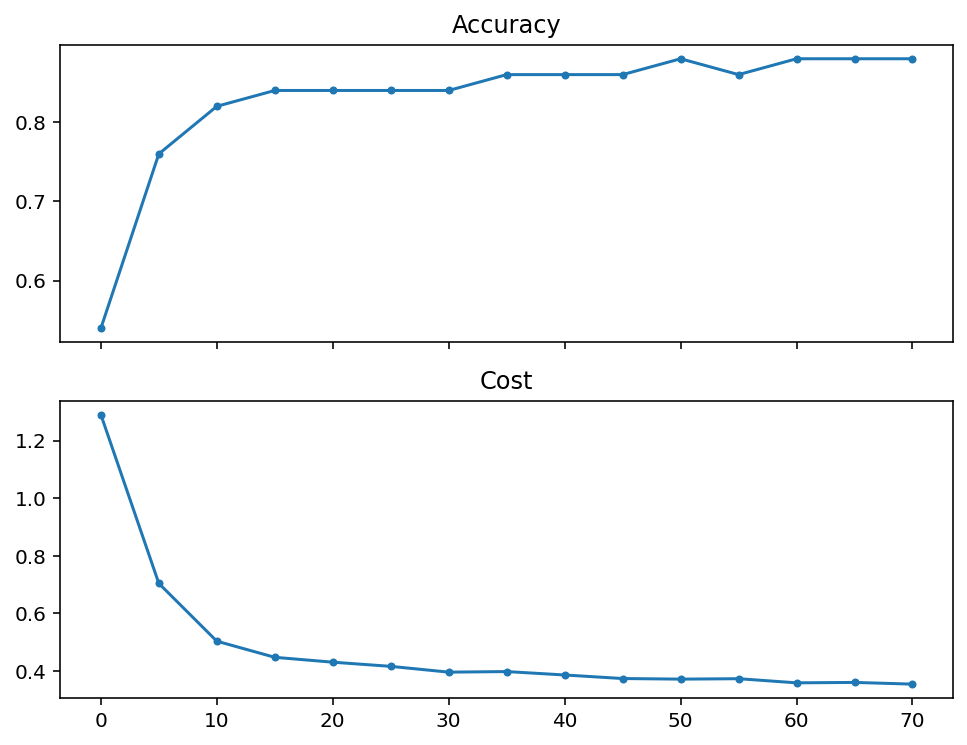

In [11]:
f, ax = plt.subplots(2, figsize=(8, 6), sharex=True)
ax[0].plot(ii, acc_, ".-")
ax[0].set_title("Accuracy")
ax[1].plot(ii, cost_, ".-")
ax[1].set_title("Cost")
plt.show()

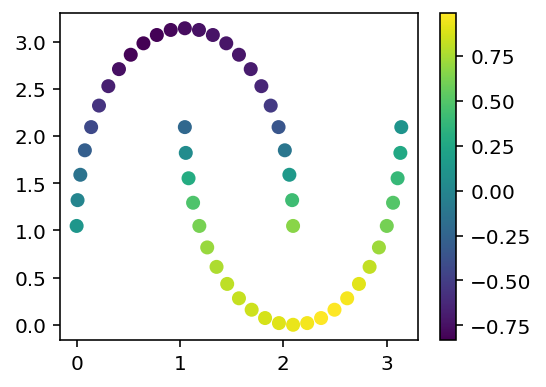

In [12]:
plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()

In [13]:
np.random.seed(42)
q = (np.random.uniform(0, np.pi, size=(4, 2, 3)), 0.0)


def naive_grad(cost, params, x, y, f0, delta):
    return (cost(params, x, y) - f0) / delta

def grad_i(q, f0, cost, x, y, i):
    new_params = q[0].copy().flatten()
    new_params[i] += 0.05

    return naive_grad(cost, (new_params.reshape(q[0].shape), q[1]), x, y, f0, 0.05)

In [14]:
grad = qml.grad(cost, argnum=0)

In [15]:
autograd = grad(q, x, y)
f0 = cost(q, x, y)
pretty_print = ""
for i in range(10):
    g_i = grad_i(q, f0, cost, x, y, i)
    pretty_print += f"Naive grad: {g_i:.3f}\tAutograd result: {autograd[0].flatten()[i]:.3f}\n"

print(pretty_print)

Naive grad: -0.028	Autograd result: -0.029
Naive grad: 0.081	Autograd result: 0.081
Naive grad: 0.025	Autograd result: 0.025
Naive grad: 0.013	Autograd result: 0.008
Naive grad: -0.000	Autograd result: -0.011
Naive grad: 0.009	Autograd result: 0.004
Naive grad: 0.025	Autograd result: 0.025
Naive grad: 0.002	Autograd result: -0.003
Naive grad: -0.068	Autograd result: -0.069
Naive grad: 0.009	Autograd result: 0.004



In [16]:
def parameter_shift_i(q, cost, x, y, i, y_hat):
    new_params = q[0].copy().flatten()
    new_params[i] += np.pi / 2

    forward = np.array(apply_node(x, (new_params.reshape(q[0].shape), q[1])))

    new_params = q[0].copy().flatten()
    new_params[i] -= np.pi / 2

    backward = np.array(apply_node(x, (new_params.reshape(q[0].shape), q[1])))

    diff = (y_hat - y)

    return np.mean(2 * diff * (0.5 * (forward - backward)))

In [17]:
y_hat = apply_node(x, q)
pretty_print = ""
for i in range(10):
    g_i = parameter_shift_i(q, cost, x, y, i, y_hat)
    pretty_print += f"Naive grad: {g_i:.3f}\tAutograd result: {autograd[0].flatten()[i]:.3f}\n"

print(pretty_print)

Naive grad: -0.029	Autograd result: -0.029
Naive grad: 0.081	Autograd result: 0.081
Naive grad: 0.025	Autograd result: 0.025
Naive grad: 0.008	Autograd result: 0.008
Naive grad: -0.011	Autograd result: -0.011
Naive grad: 0.004	Autograd result: 0.004
Naive grad: 0.025	Autograd result: 0.025
Naive grad: -0.003	Autograd result: -0.003
Naive grad: -0.069	Autograd result: -0.069
Naive grad: 0.004	Autograd result: 0.004

